In [174]:
import pandas as pd
import numpy as np
import xgboost as xgb
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import warnings

In [175]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
final_district_xgb_model = xgb.Booster()
final_district_xgb_model.load_model('models/final_district_xgb_model.json')

In [3]:
final_district_xgb_model

In [7]:
top_features = [
    'bus_stops_distance_0.1',
    'alleylights_distance_0.1',
    'police_stations_distance_1',
    'streetlights_oneout_distance_0.1',
    'streetlights_allout_distance_0.5',
    'streetlights_oneout_distance_0.3',
    'streetlights_allout_distance_0.3',
    'bike_rides_within_0.5_and_15_min',
    'area_crimes_3_hours_prev',
    'area_crimes_1_hours_prev',
    'alleylights_distance_0.3',
    'bike_rides_within_0.1_and_10_min',
    'bike_rides_within_0.1_and_5_min',
]

In [13]:
area_df = pd.read_csv('../../data/pre_training/area_pre_feature_selection_nonnormalized.csv')
dis_area_df = pd.read_csv('../../data/pre_training/dis_area_pre_feature_selection_nonnormalized.csv')
district_df = pd.read_csv('../../data/pre_training/district_pre_feature_selection_nonnormalized.csv')

In [14]:
area_df_selected = area_df[top_features]
dis_area_df_selected = dis_area_df[top_features]
district_df_selected = district_df[top_features]

In [4]:
factor_mapping = {
    'Bike Activity': [
        'bike_rides_within_0.5_and_15_min', 
        'bike_rides_within_0.1_and_10_min', 
        'bike_rides_within_0.1_and_5_min'
    ],
    'Alleylight Availability': [
        'alleylights_distance_0.1',
        'alleylights_distance_0.3'
    ],
    'Streetlight Outages': [
        'streetlights_allout_distance_0.5',
        'streetlights_allout_distance_0.3'
    ],
    'Partial Streetlight Outages': [
        'streetlights_oneout_distance_0.1',
        'streetlights_oneout_distance_0.3'
    ],
    'Recent Crime Activity': [
        'area_crimes_3_hours_prev',
        'area_crimes_1_hours_prev'
    ]
}

In [206]:
def simulation(df, ref_df, thresholds):
    simmed_dfs = {}
    
    for factor in factor_mapping.keys():
        target_cols = factor_mapping[factor]

        for threshold in thresholds:
            threshold = round(threshold, 2)
            temp_df = df.copy()

            if threshold < 0:
                random_factors = np.random.uniform(1 - abs(threshold), 1, size=temp_df[target_cols].shape)
                temp_df.loc[:, target_cols] = temp_df[target_cols] * random_factors
            else:
                random_factors = np.random.uniform(1, 1 + threshold, size=temp_df[target_cols].shape)
                random_additions = np.random.choice([0, 1], size=temp_df[target_cols].shape, p=[1 - threshold, threshold])
                temp_df.loc[:, target_cols] = (temp_df[target_cols] + random_additions) * random_factors

            temp_df = pd.concat([temp_df, ref_df], axis=1)
            simmed_dfs[f'{factor.replace(" ", "_").lower()}_{threshold}'] = temp_df

    return simmed_dfs

In [207]:
district_sims = simulation(district_df[top_features], district_df[['district', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])
area_sims = simulation(area_df[top_features], area_df[['area_id', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])
dis_area_sims = simulation(dis_area_df[top_features], dis_area_df[['dis_area_id', 'date_hour']], [-0.1, -0.05, 0.05, 0.1])

##### Rerun model with the new dataset

In [210]:
def predict_simulations(model, drops, sim_dfs):
    predictions = {}
    for threshold, sim_df in sim_dfs.items():
        dmatrix = xgb.DMatrix(sim_df.drop(drops, axis=1))
        prediction = model.predict(dmatrix)
        predictions[threshold] = prediction

        print(f'Predictions for {threshold} completed')

    return predictions

In [211]:
district_predictions = predict_simulations(final_district_xgb_model, ['district', 'date_hour'], district_sims)

In [128]:
area_predictions = predict_simulations(final_district_xgb_model, ['area_id', 'date_hour'], area_sims)

Predictions for bike_activity_-0.1 completed
Predictions for bike_activity_-0.05 completed
Predictions for bike_activity_0.0 completed
Predictions for bike_activity_0.05 completed
Predictions for bike_activity_0.1 completed
Predictions for alleylight_availability_-0.1 completed
Predictions for alleylight_availability_-0.05 completed
Predictions for alleylight_availability_0.0 completed
Predictions for alleylight_availability_0.05 completed
Predictions for alleylight_availability_0.1 completed
Predictions for streetlight_outages_-0.1 completed
Predictions for streetlight_outages_-0.05 completed
Predictions for streetlight_outages_0.0 completed
Predictions for streetlight_outages_0.05 completed
Predictions for streetlight_outages_0.1 completed
Predictions for partial_streetlight_outages_-0.1 completed
Predictions for partial_streetlight_outages_-0.05 completed
Predictions for partial_streetlight_outages_0.0 completed
Predictions for partial_streetlight_outages_0.05 completed
Predictions 

In [132]:
dis_area_predictions = predict_simulations(final_district_xgb_model, ['dis_area_id', 'date_hour'], dis_area_sims)

Predictions for bike_activity_-0.1 completed
Predictions for bike_activity_-0.05 completed
Predictions for bike_activity_0.05 completed
Predictions for bike_activity_0.1 completed
Predictions for alleylight_availability_-0.1 completed
Predictions for alleylight_availability_-0.05 completed
Predictions for alleylight_availability_0.05 completed
Predictions for alleylight_availability_0.1 completed
Predictions for streetlight_outages_-0.1 completed
Predictions for streetlight_outages_-0.05 completed
Predictions for streetlight_outages_0.05 completed
Predictions for streetlight_outages_0.1 completed
Predictions for partial_streetlight_outages_-0.1 completed
Predictions for partial_streetlight_outages_-0.05 completed
Predictions for partial_streetlight_outages_0.05 completed
Predictions for partial_streetlight_outages_0.1 completed
Predictions for recent_crime_activity_-0.1 completed
Predictions for recent_crime_activity_-0.05 completed
Predictions for recent_crime_activity_0.05 completed


##### Calculate Residuals Across Geospatial Factors

In [139]:
def calculate_residuals(predictions, test_labels, geodata):
    residuals = {}
    for threshold, prediction in predictions.items():
        temp_df = pd.DataFrame(data={'geo':geodata, 'actual_crime':test_labels, 'new_crime':prediction})
        avg_grouped_residuals = temp_df.groupby('geo')[['actual_crime', 'new_crime']].agg('mean').reset_index()
        avg_grouped_residuals.rename(columns={'actual_crime':'avg_actual_crime', 'new_crime':'avg_new_crime'}, inplace=True)
        avg_grouped_residuals['avg_diff'] = avg_grouped_residuals['avg_actual_crime'] - avg_grouped_residuals['avg_new_crime']
        avg_grouped_residuals['avg_perc_diff'] = (avg_grouped_residuals['avg_new_crime'] - avg_grouped_residuals['avg_actual_crime']) / avg_grouped_residuals['avg_actual_crime'] * 100

        tot_grouped_residuals = temp_df.groupby('geo')[['actual_crime', 'new_crime']].agg('sum').reset_index()
        tot_grouped_residuals.rename(columns={'actual_crime':'tot_actual_crime', 'new_crime':'tot_new_crime'}, inplace=True)
        tot_grouped_residuals['tot_diff'] = tot_grouped_residuals['tot_actual_crime'] - tot_grouped_residuals['tot_new_crime']
        tot_grouped_residuals['tot_perc_diff'] = (tot_grouped_residuals['tot_new_crime'] - tot_grouped_residuals['tot_actual_crime']) / tot_grouped_residuals['tot_actual_crime'] * 100

        residuals[threshold] = pd.merge(avg_grouped_residuals, tot_grouped_residuals, on='geo', how='inner')
    
    return residuals

In [140]:
district_residuals = calculate_residuals(district_predictions, district_df['district_crimes_this_hour'], district_df['district'])

In [142]:
area_residuals = calculate_residuals(area_predictions, area_df['area_crimes_this_hour'], area_df['area_id'])

In [144]:
dis_area_residuals = calculate_residuals(dis_area_predictions, dis_area_df['dis_area_crimes_this_hour'], dis_area_df['dis_area_id'])

##### Visualize the Differences

In [103]:
clean_police_districts = pd.read_csv('../../data/processed/clean_police_districts.csv')
clean_areas = pd.read_csv('../../data/processed/clean_areas.csv')
disadvantaged_areas_within_areas = pd.read_csv('../../data/processed/disadvantaged_areas_within_areas.csv')

In [105]:
def parse_polygon(polygon_string):
    points = polygon_string.strip('POLYGON ((').strip('))').split(', ')
    points = [tuple(map(float, point.split())) for point in points]
    return Polygon(points)

In [106]:
def swap_coordinates(polygon):
    if polygon.is_empty:
        return polygon
    swapped_coords = [(y, x) for x, y in polygon.exterior.coords]
    return Polygon(swapped_coords)

In [107]:
clean_police_districts['geom'] = clean_police_districts['geom'].apply(parse_polygon)
clean_police_districts['geom'] = clean_police_districts['geom'].apply(swap_coordinates)
clean_police_districts.head()

,district,geom,disadvantaged_score,disadvantaged_score.1,centroid,status,areas
0,17,POLYGON ((-87.71067089391354 41.99736565536943...,0.0,0.0,0.0,0.0,0.0
1,20,POLYGON ((-87.66029423572358 41.99091633853977...,4.0,4.0,4.0,4.0,4.0
2,31,POLYGON ((-87.82817787271652 41.98384222028714...,0.0,0.0,0.0,0.0,0.0
3,31,POLYGON ((-87.83365455160555 41.97535481526603...,0.0,0.0,0.0,0.0,0.0
4,19,POLYGON ((-87.64491798568677 41.96972709381482...,2.0,2.0,2.0,2.0,2.0


In [108]:
clean_areas['poly'] = clean_areas['poly'].apply(parse_polygon)
clean_areas['poly'] = clean_areas['poly'].apply(swap_coordinates)
clean_areas.head()

,id,poly,district
0,35,POLYGON ((-87.60914087617894 41.84469250265398...,2
1,36,POLYGON ((-87.59215283879394 41.81692934626684...,2
2,37,POLYGON ((-87.62879823733725 41.80189303368919...,9
3,38,"POLYGON ((-87.6067081256125 41.81681377057218,...",2
4,39,POLYGON ((-87.59215283879394 41.81692934626684...,2


In [109]:
disadvantaged_areas_within_areas['poly'] = disadvantaged_areas_within_areas['poly'].apply(parse_polygon)
disadvantaged_areas_within_areas['poly'] = disadvantaged_areas_within_areas['poly'].apply(swap_coordinates)
disadvantaged_areas_within_areas['id'] = disadvantaged_areas_within_areas.index
disadvantaged_areas_within_areas.head()

,poly,district,areas,id
0,POLYGON ((-87.57366299996758 41.70796600003142...,4,51,0
1,POLYGON ((-87.60151899995586 41.68632499999862...,5,50,1
2,POLYGON ((-87.60036199996543 41.69284299996604...,5,50,2
3,POLYGON ((-87.62032800000847 41.69942700001048...,5,49,3
4,POLYGON ((-87.66036699995497 41.75771799998948...,6,71,4


In [111]:
clean_areas.rename(columns={'id':'area', 'poly':'geom'}, inplace=True)
disadvantaged_areas_within_areas.rename(columns={'id':'area', 'poly':'geom'}, inplace=True)

In [112]:
geo_districts = gpd.GeoDataFrame(clean_police_districts[['district','geom']], geometry='geom')
geo_areas = gpd.GeoDataFrame(clean_areas[['area','geom']], geometry='geom')
geo_dis_areas = gpd.GeoDataFrame(disadvantaged_areas_within_areas[['area','geom']], geometry='geom')

In [99]:
chicago = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))

In [125]:
def plot_normalized_heatmap(geo_df, target_column, t, title, threshold=0.1, label=True, background=True, savefig=None):
    merged_gdf = geo_df.merge(target_column, left_on=t, right_on='geo')
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="#f9f9f6")
    ax.set_facecolor("#e0e0e0")

    if background:
        chicago.plot(color='lightgrey', alpha=1, ax=ax)

    merged_gdf.plot(column=target_column.columns[1], cmap='OrRd', ax=ax)

    sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.036, pad=0.1)
    cbar.set_ticks([0, 1])
    cbar.ax.set_xticklabels(['Low', 'High'])

    cbar.outline.set_visible(False)

    if label:
        for _, row in merged_gdf.iterrows():
            if row[target_column] > 1 - threshold:
                plt.text(row.geom.centroid.x, row.geom.centroid.y, s=row[t], 
                    horizontalalignment='center', verticalalignment='center', fontsize=10, color='white', fontweight='bold')
            elif row[target_column] < threshold:
                plt.text(row.geom.centroid.x, row.geom.centroid.y, s=row[t], 
                        horizontalalignment='center', verticalalignment='center', fontsize=10, color='black', fontweight='bold')      

    tit = f"The Impact of {target_column.columns[1]} On Each \n {title}'s Total Crime"

    plt.title(tit, fontsize=14, pad=14)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    if savefig is not None:
        plt.savefig(savefig)

    plt.show()

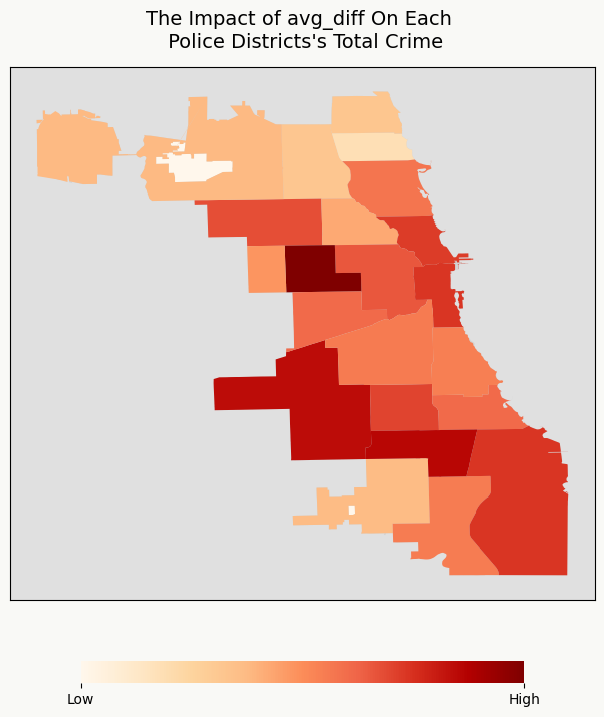

In [126]:
plot_normalized_heatmap(geo_districts, district_residuals['alleylight_availability_-0.1'][['geo', 'avg_diff']], 'district', 'Police Districts', label=False)